<a href="https://colab.research.google.com/github/TillVollmer5/mass_spectroscopy/blob/main/Calibration_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibration calculation
This skript aims to allow the calculation and generation of a linear regression to allow the quantivication of phthalates in the environement.

nput: The the peak list files (classic structure, header = 6, by thermofisher) are uploaded to the directory titeled *calibration_input*, it is of key importance that the title of the files follows the format: Cal_"conc.nr"_"series.nr"_"identification.nr"_pl.csv Any changes to filename, path or other changes that might impact the file significantly need to be comented and marked extensively.

The following code serves to import the librarys and mount the google drive.

In [90]:
import numpy as np
from google.colab import drive
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import re

drive.mount('/content/drive', force_remount = True)

# Read the list of strings from a CSV file to get the x_values
strings = []
with open('/content/drive/My Drive/calibration_input/x_values.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        strings.extend(row)

values = []
for string in strings:
    split_values = string.split(';')
    non_empty_values = [value for value in split_values if value.strip()]
    values.extend(non_empty_values)
values.reverse()

values_float = []
for value in values:
    if value.startswith('0'):
        value_float = '0.' + value[1:]
    else:
        value_float = value
    values_float.append(float(value_float))

print(values_float)
print(strings)
print(values)

Mounted at /content/drive
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
['4', '2', '1', '05', '025', '0125', '00625', '003125', '0015625', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['0015625', '003125', '00625', '0125', '025', '05', '1', '2', '4']


This loop aims at importing the various files from the google drive, looping throug the colums and saving them in a new file.

In [65]:

for n in values:
    files = glob.glob(f'/content/drive/My Drive/calibration_input/Cal_{n}ug*.csv')
    
    if not files:
        print(f'Files matching pattern "Cal_{n}ug*.csv" were not found.')
        break
    
    else:
        # Loop over each row and save a separate data frame for each
        df = pd.read_csv(files[0], header=4)
        num_rows = len(df)
        
        for i in range(num_rows):
            row_dfs = []
            for file in files:
                df = pd.read_csv(file, header=4, na_values='')

                # Extract the i'th row of the CSV file and append it to the row data frame list
                row = df.iloc[i, :].dropna().astype(str)
                row_dfs.append(row)

            # Concatenate the row data frames along the columns axis and convert to a data frame
            combined_df = pd.concat(row_dfs, axis=1).T

            # Save the combined data frame to a CSV file with a name indicating the row number
            combined_df.to_csv(f'/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row{i+1}.csv', index=False, header=False, sep=';')
            
            # Convert all values to strings before joining and print the row in the desired format
            formatted_row = '\t'.join(map(str, combined_df.values[0]))
            print(formatted_row)


14.7	14.65	14.77	26849041544.845	13.73	11753696416.516	14.64
17.49	17.43	17.56	31010418793.068	15.86	14249815334.221	17.75
20.79	20.74	20.86	25952918673.635	13.27	11385240228.016	14.19
23.92	23.87	23.99	36600593972.704	18.71	16750692100.573	20.87
29.63	29.57	29.76	23563292873.163	12.05	9887409554.39	12.32
32.17	32.11	32.35	29234189302.874	14.95	10558235993.659	13.16
34.56	34.5	34.84	22371990911.84	11.44	5673482422.795	7.07
14.71	14.65	14.76	8952207731.725	10.26	4226292693.475	11.55
17.49	17.44	17.54	11998116826.662	13.75	5828840761.315	15.93
20.8	20.75	20.86	22520126789.463	25.81	10021203051.475	27.38
23.93	23.88	24.01	16039501864.43	18.38	7877642340.717	21.53
29.64	29.58	29.78	8342456720.914	9.56	3252297038.529	8.89
32.17	32.11	32.47	12022141515.246	13.78	3620206438.565	9.89
34.57	34.51	34.85	7387936509.543	8.47	1767888360.067	4.83
11.77	11.74	11.82	3342032614.23	5.05	1605160822.331	5.6
14.7	14.66	14.75	4256075648.707	6.43	1979774641.943	6.91
17.48	17.44	17.55	5619948726.242	8.49	2770

The following lines use the previously created row file and take the average and the standard deviation *(or the error)* and add them to two new files.

In [44]:
files = glob.glob('/content/drive/My Drive/calibration_output/Cal_*.csv')
# Loop over each file
for file in files:
    df = pd.read_csv(file, header=None)
    
    # Calculate the mean and standard deviation
    df_mean = df.mean(axis=0)
    df_mean = df_mean.transpose().to_frame().T
    df_std = df.std(axis=0)
    df_std = df_std.transpose().to_frame().T

    #print(df_mean)
    #print(df_std)
    
    file_name = os.path.basename(file)
    
    mean_file_path = '/content/drive/My Drive/calibration_output/' + file_name[:-4] + '_mean.csv'
    df_mean.to_csv(mean_file_path, index=False)
    
    std_file_path = '/content/drive/My Drive/calibration_output/' + file_name[:-4] + '_std.csv'
    df_std.to_csv(std_file_path, index=False)


<ipython-input-44-5fc8186e613a>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mean = df.mean(axis=0)
<ipython-input-44-5fc8186e613a>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_std = df.std(axis=0)
<ipython-input-44-5fc8186e613a>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mean = df

Two files contain the internal standard signals are used to take the ratio of the various signals and save the values in a new file. The file needs to be specified so that the internal standard signal correlates to the divisor name, so that this leads to the correct ratio. The first one calculates the ratio of the mean and the bottom one being used for the ratio of the standard deviation, although that might be insuficient and should be substituted by an appropriate error calculation (possibly gaussian errorpropagation).

In [66]:
directory = '/content/drive/My Drive/calibration_output'

for n in values:
    divisor_file = f'/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row3.csv'
    
    divisor_row = pd.read_csv(divisor_file, sep=';', header=None)
    print(divisor_row)
    divisor_row = divisor_row.apply(pd.to_numeric, errors='coerce')  # Convert values to numeric
    print(divisor_row)
    csv_files = glob.glob(os.path.join(directory, f'Cal_{n}ug_ml_*.csv'))

    # Process each CSV file
    for csv_file in csv_files:
        if csv_file == divisor_file:
            continue  # Skip the divisor file itself

        data_df = pd.read_csv(csv_file, sep=';', header=None)
        print(data_df)
        data_df = data_df.apply(pd.to_numeric, errors='coerce')  # Convert values to numeric
      
        # Perform division on the data
        divided_data_df = data_df.div(divisor_row, axis='columns')
        print(divided_data_df)
        # Create a new file name with the "_ratio" tag
        new_file_name = os.path.splitext(csv_file)[0] + '_ratio.csv'

        divided_data_df.to_csv(new_file_name, sep='\t', header=False, index=False)


       0      1      2             3      4             5      6
0  20.79  20.74  20.86  2.595292e+10  13.27  1.138524e+10  14.19
       0      1      2             3      4             5      6
0  20.79  20.74  20.86  2.595292e+10  13.27  1.138524e+10  14.19
      0      1      2             3      4             5      6
0  14.7  14.65  14.77  2.684904e+10  13.73  1.175370e+10  14.64
          0         1         2         3         4         5         6
0  0.707071  0.706365  0.708054  1.034529  1.034665  1.032363  1.031712
       0      1      2             3      4             5      6
0  17.49  17.43  17.56  3.101042e+10  15.86  1.424982e+10  17.75
         0         1         2         3         4         5         6
0  0.84127  0.840405  0.841802  1.194872  1.195177  1.251604  1.250881
       0      1      2             3      4             5      6
0  23.92  23.87  23.99  3.660059e+10  18.71  1.675069e+10  20.87
          0         1         2         3         4         5     

The following script creates a plot using the previously optained data. A file containing the concentration will be nescessary to associate the y-axis values with the x-axis values.

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[1.0345287897087412], [0.3975203077415031], [0.5946731504194314], [0.0470955114111522], [0.0283675921744845], [0.0193768170099287], [0.006253151411277], [0.0032894685043855], [0.0011687724731029]]


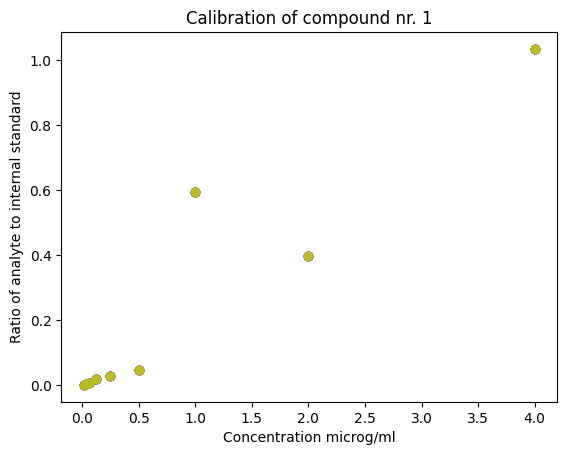

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[1.1948721137315013], [0.5327730584658977], [0.7573157436176455], [0.0638179762562752], [0.0334502229906293], [0.023507462832229], [0.0069839410268804], [0.0037016122964834], [0.0014457679484853]]


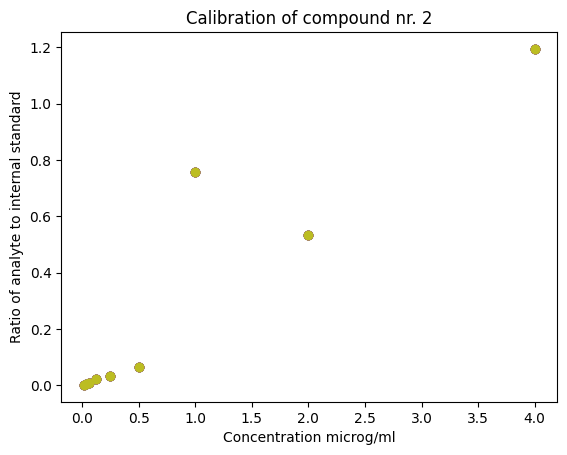

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[]


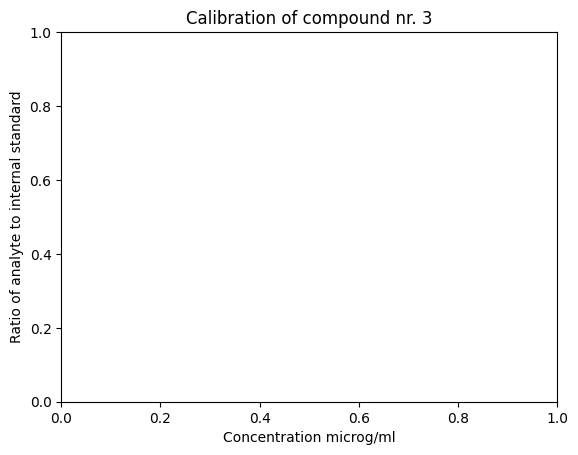

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[1.4102688962642858], [0.7122296430380118], [6.399605762620492], [0.077482212312528], [0.034081536616389], [0.0224994387530132], [0.0063527669848194], [0.0029371885918226], [0.0012376416966807]]


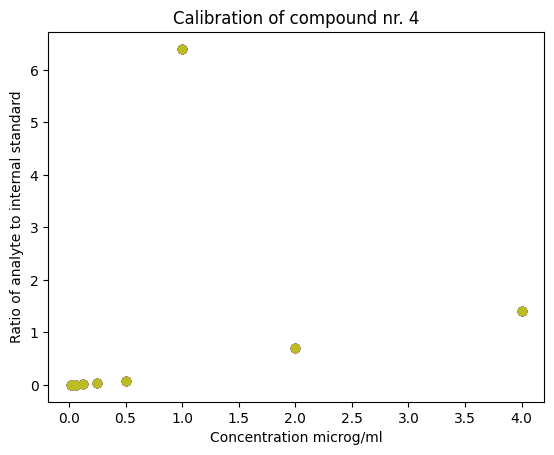

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[0.9079245833379208], [0.3704444827911614], [1.301794051317821], [0.0312213836464174], [0.0136844756424105], [0.0078014485544302], [0.0020828081390452], [0.0008968117443915], [0.0004219237762564]]


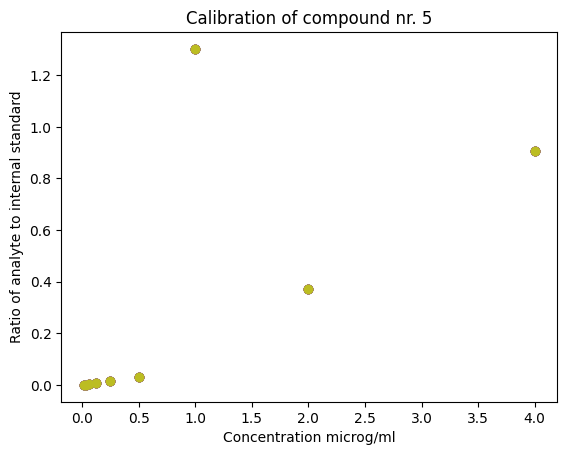

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[1.1264316615214602], [0.5338398681161542], [0.5965242818821478], [0.0340036937749463], [0.0121601779703526], [0.0080522947080455], [0.0019349264466794], [0.0008455415790846], [0.0003895055084556]]


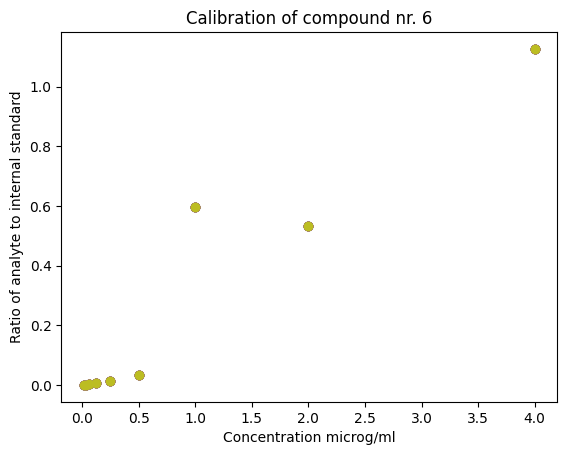

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
[[0.8620221560886412], [0.3280592768687146], [0.7092548128403263], [0.0194272256721983], [0.0074194245980317], [0.0041437535174762], [0.0009807799977765], [0.0004393969432763], [0.0002035702517563]]


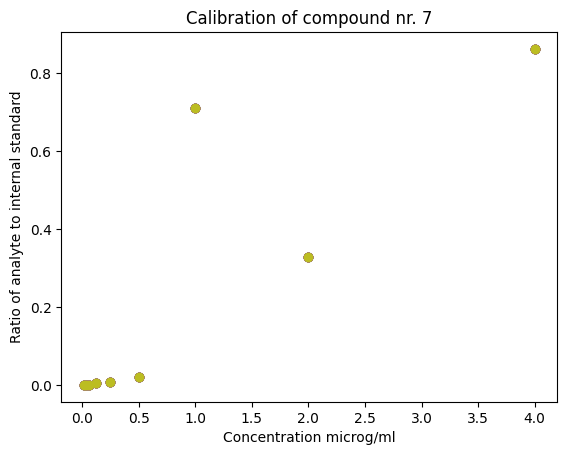

In [91]:
comp_1 = 1
comp_fin = 8

for n in range(comp_1, comp_fin):
    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')

    y_values = []  # Initialize an empty list for y-values

    for file in files:
        y_data = pd.read_csv(file, header=None, sep='\t')  # Specify tab as the separator
        #print(y_data.head())
        if not y_data.empty:
            if y_data.shape[1] >= 4:  # Check if the DataFrame has at least four columns
                y_values.append(y_data.iloc[:, 3].tolist())  # Access the fourth column by index
            else:
                print(f"DataFrame does not have the fourth column: {file}")
        else:
            print(f"Empty DataFrame: {file}")

    print(values_float)
    print(y_values)

    fig, ax = plt.subplots()

    for y in y_values:
        ax.scatter(values_float, list(reversed(y_values)))  # Use x_values[:len(y)] to match the dimensions, change to ax.plot later...

    ax.set_xlabel("Concentration microg/ml")
    ax.set_ylabel("Ratio of analyte to internal standard")
    ax.set_title(f"Calibration of compound nr. {n}")

    plt.savefig(f"/content/drive/My Drive/calibration_output/Cal_{n}_analyte_calibration_curve.pdf")
    plt.show()


The following code allows to fit a linear regretion, in coordination with the data for the various compounds, where the first section is no different than the code defining the x and y axes in the skript used to plot the linear function

In [104]:
comp_1 = 1
comp_fin = 8

for n in range(comp_1, comp_fin):
    if n==3:
      continue
    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')
    print(files)
    y_values = []  # Initialize an empty list for y-values

    for file in files:
        y_data = pd.read_csv(file, header=None, sep='\t')  # Specify tab as the separator
        print(y_data.head())
        if not y_data.empty:
            if y_data.shape[1] >= 4:  # Check if the DataFrame has at least four columns
                y_values.append(y_data.iloc[:, 3].tolist()) # Access the fourth column by index
            else:
                print(f"DataFrame does not have the fourth column: {file}")
        else:
            print(f"Empty DataFrame: {file}")

    values_float = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]  # Replace with your actual values

    x_values = np.array(values_float).reshape(-1, 1)  # Access the first column by index and reshape to a 2D array

    print(x_values)
    print(y_values)
    
    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(x_values, y_values)

    # Predict using the model
    y_pred = model.predict(x_values)

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)

    # Get the learned coefficients
    intercept = model.intercept_
    slope = model.coef_

    # Define the output file path
    output_file = f"/content/drive/My Drive/calibration_output/Cal_{n}_analyte_linreg.csv"

    # Write the output to a CSV file
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Intercept", "Slope", "R2 Value"])
        writer.writerow([intercept, slope, r2])

    print("Output saved to:", output_file)


['/content/drive/My Drive/calibration_output/Cal_4ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_2ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_1ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_05ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_025ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0125ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_00625ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_003125ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0015625ug_ml_row1_ratio.csv']
          0         1         2         3         4         5         6
0  0.707071  0.706365  0.708054  1.034529  1.034665  1.032363  1.031712
          0         1         2        3        4         5         6
0  0.707212  0.706024  0.707574  0.39752  0.39752  0.421735  0.421841
          0         1         2         3     